In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow.keras.models import Sequential

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, MaxPooling2D, Dropout

In [28]:
(train, validation), info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [29]:
def preprocess(image,label):
  image = tf.image.resize(image,[150,150])
  image = tf.cast(image, tf.float32)/255.0
  return image, label

In [30]:
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image,label

In [31]:
train = train.map(preprocess).map(augment).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.map(preprocess).map(augment).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
from tensorflow.keras.applications import VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [33]:
for layer in vgg.layers:
  layer.trainable = False

In [34]:
model = Sequential([
    vgg,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='sigmoid')
])

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_accuracy', patience=5)

In [37]:
history = model.fit(train, epochs=100, validation_data = validation, callbacks=[callback])

Epoch 1/100
 97/582 ━━━━━━━━━━━━━━━━━━━━ 1:08:56 9s/step - accuracy: 0.7190 - loss: 0.6736

KeyboardInterrupt: 

In [38]:
import matplotlib.pyplot as plt
def display_predictions(data,model,images=5):
  plt.figure(figsize=(15,3))
  for i, (img,label) in enumerate(data.unbatch().take(images)):
    actual = 'Dog' if label.numpy() == 1 else 'Cat'

    predictions = model.predict(tf.expand_dims(img,0))
    predic_label = 'Dog' if predictions[0][0] > 0.5 else 'Cat'

    plt.subplot(1, images, i+1)
    plt.imshow(img.numpy().astype("int32"))
    plt.title(f'A: {actual}\nP: {predic_label}')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


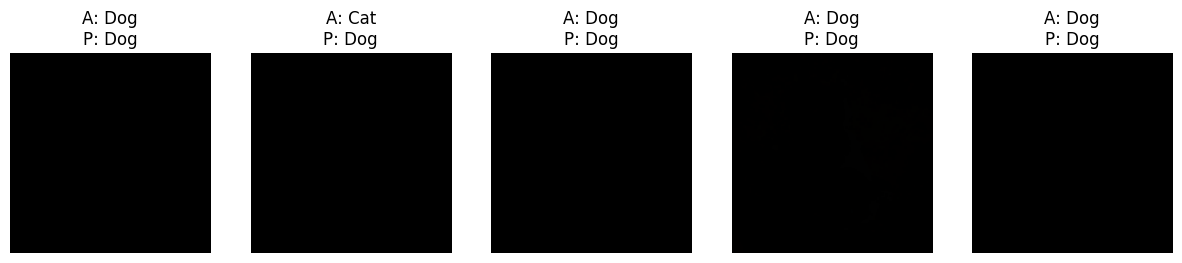

In [39]:
display_predictions(validation, model)